In [228]:
# export
import torch
import torch.nn as nn

import requests
import pickle

import gzip
from pathlib import Path

In [230]:
# export
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl.gz'

def download_file(url:str, folder:str):
    folder = Path(folder)
    files = [x.name for x in folder.glob('**/*') if x.is_file()]
    filename = url.split('/')[-1]
    if filename in files:
        print(f"File {filename} already exists in {folder}")
        return folder / filename
    r = requests.get(url)
    with open(folder / filename, 'wb') as f:
        f.write(r.content)
    return folder / filename

def get_data():
    path = download_file(MNIST_URL, './data')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(torch.tensor, (x_train,y_train,x_valid,y_valid))

In [17]:
x_train,y_train,x_valid,y_valid = get_data()

File mnist.pkl.gz already exists in data


In [18]:
n = x_train.shape[0]
n_in = m = torch.tensor(x_train.shape[1:]).prod().item()

In [19]:
n_h = 50
n_out = c = y_train.max().item() + 1
n, m, c

(50000, 784, 10)

In [20]:
class Model(nn.Module):
    def __init__(self, n_in, n_h, n_out):
        super().__init__()
        self.n_in = n_in
        self.layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_out)]
    
    def __call__(self, x):
        for l in self.layers: 
            x = l(x)
        return x

In [21]:
model = Model(m, n_h,10)

In [22]:
preds = model(x_train)

In [23]:
preds.max(), preds.min()

(tensor(0.4803, grad_fn=<MaxBackward1>),
 tensor(-0.4972, grad_fn=<MinBackward1>))

In [24]:
def log_softmax(x):
    return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [25]:
lsm_pred = log_softmax(preds)

In [26]:
def nll(input, target):
    return -input[range(input.shape[0]), target].mean()

In [27]:
loss = nll(lsm_pred, y_train)
loss

tensor(2.3096, grad_fn=<NegBackward>)

vanishes due to exp overflow/underflow in log_softmax

In [28]:
def logsumexp(x):
    max_ = x.max(-1)[0] # values not indices
    return max_ + (x - max_[:, None]).exp().sum(-1).log()

In [29]:
def log_softmax2(x): 
    return x - x.logsumexp(-1,keepdim=True)

In [30]:
lsm_pred = log_softmax2(preds)
loss = nll(lsm_pred, y_train)
loss

tensor(2.3096, grad_fn=<NegBackward>)

In [31]:
logsumexp(preds).shape

torch.Size([50000])

In [32]:
from torch.nn import functional as F

In [33]:
lsm_preds = F.log_softmax(preds, -1)
F.nll_loss(lsm_pred, y_train)

tensor(2.3096, grad_fn=<NllLossBackward>)

In [34]:
F.cross_entropy(preds, y_train)

tensor(2.3096, grad_fn=<NllLossBackward>)

## Basic training loop

In [35]:
loss_func = F.cross_entropy

In [36]:
# export
def accuracy(preds, target):
    return (preds.argmax(axis=1) == target).float().mean()

In [37]:
accuracy(preds, y_train)

tensor(0.1325)

In [38]:
bs = 64

xb = x_train[:bs]
yb = y_train[:bs]

preds = model(xb)

In [39]:
loss_func(preds, yb)

tensor(2.3349, grad_fn=<NllLossBackward>)

In [40]:
accuracy(preds, yb)

tensor(0.0625)

In [41]:
epochs = 10
lr = 0.01

for epoch in range(epochs):
    for i in range( (n-1)//bs +1):
        start_i = bs*i
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        preds = model(xb)
        loss = loss_func(preds, yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= lr * l.weight.grad
                    l.weight.grad.zero_()
                    l.bias -= lr * l.bias.grad
                    l.bias.grad.zero_()

In [42]:
loss_func(model(xb), yb)

tensor(0.3736, grad_fn=<NllLossBackward>)

In [43]:
accuracy(model(xb), yb)

tensor(0.8750)

In [44]:
class DummyModule():
    def __init__(self, nin, nh, nout):
        self._modules = {}
        self.l1 = nn.Linear(nin, nh)
        self.l2 = nn.Linear(nh, nout)
    
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self): return f"{self._modules}"
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [45]:
model2 = DummyModule(n_in, n_h, n_out)
model2

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [46]:
model2.parameters()

<generator object DummyModule.parameters at 0x7f192d845360>

In [47]:
list([x.shape for x in model2.parameters()])

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [48]:
class Model(nn.Module):
    def __init__(self, nin, nh, nout):
        super().__init__()
        self.l1 = nn.Linear(nin, nh)
        self.l2 = nn.Linear(nh, nout)
        
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [49]:
model = Model(n_in, n_h, n_out)
list(model.named_children())

[('l1', Linear(in_features=784, out_features=50, bias=True)),
 ('l2', Linear(in_features=50, out_features=10, bias=True))]

In [50]:
loss_func(model(xb), yb)

tensor(2.2898, grad_fn=<NllLossBackward>)

In [51]:
epochs = 10
lr = 0.01

def fit():
    for epoch in range(epochs):
        for i in range( (n-1)//bs +1):
            start_i = bs*i
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad
                model.zero_grad()

In [52]:
def stats():
    return loss_func(model(xb), yb), accuracy(model(xb), yb)

In [53]:
stats()

(tensor(2.2898, grad_fn=<NllLossBackward>), tensor(0.0625))

In [54]:
fit(); stats()

(tensor(0.3843, grad_fn=<NllLossBackward>), tensor(0.8750))

## Registering modules

In [55]:
layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_out)]

In [56]:
class Model(nn.Module):
    
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(layers):
            self.add_module(f'layer_{i}', l)
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [57]:
model = Model(layers)
stats()

(tensor(2.3190, grad_fn=<NllLossBackward>), tensor(0.0625))

In [58]:
fit()
stats()

(tensor(0.3933, grad_fn=<NllLossBackward>), tensor(0.8750))

In [59]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [60]:
model = SequentialModel(layers)
stats()

(tensor(0.3933, grad_fn=<NllLossBackward>), tensor(0.8750))

In [61]:
fit(); stats()

(tensor(0.2274, grad_fn=<NllLossBackward>), tensor(0.8750))

In [62]:
model = nn.Sequential(nn.Linear(n_in,n_h), nn.ReLU(), nn.Linear(n_h, n_out))

In [63]:
fit(); stats()

(tensor(0.3848, grad_fn=<NllLossBackward>), tensor(0.8750))

In [64]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [65]:
class Optimizer:

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.params:
                p.grad.data.zero_()

In [66]:
model = nn.Sequential(nn.Linear(n_in,n_h), nn.ReLU(), nn.Linear(n_h, n_out))
opt = Optimizer(model.parameters(), 0.01)

In [67]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        print(loss)

In [68]:
stats()

(tensor(2.2614, grad_fn=<NllLossBackward>), tensor(0.2500))

In [69]:
fit(); stats()

tensor(1.0969, grad_fn=<NllLossBackward>)
tensor(0.8751, grad_fn=<NllLossBackward>)
tensor(0.7757, grad_fn=<NllLossBackward>)
tensor(0.7055, grad_fn=<NllLossBackward>)
tensor(0.6514, grad_fn=<NllLossBackward>)
tensor(0.6057, grad_fn=<NllLossBackward>)
tensor(0.5656, grad_fn=<NllLossBackward>)
tensor(0.5303, grad_fn=<NllLossBackward>)
tensor(0.5004, grad_fn=<NllLossBackward>)
tensor(0.4737, grad_fn=<NllLossBackward>)


(tensor(0.4101, grad_fn=<NllLossBackward>), tensor(0.8750))

In [231]:
# export
import torch.optim as optim

In [71]:
optim.SGD.step??

Signature: optim.SGD.step(self, closure=None)
Source:   
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['mome

In [72]:
lr = 0.1

In [73]:
def get_model():
    model = nn.Sequential(nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_out))
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt

In [74]:
loss_func = nn.CrossEntropyLoss()
epochs = 10
bs = 64

In [75]:
model, opt = get_model()

In [76]:
# loss_func(model(xb), yb)

In [77]:
loss_func

CrossEntropyLoss()

In [78]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [79]:
accuracy(model(xb), yb)

tensor(1.)

## Dataset

In [232]:
# export
class Dataset:
    def __init__(self, x, y):
        assert len(x)==len(y)
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [83]:
ds_train = Dataset(x_train, y_train)
ds_valid  = Dataset(x_valid, y_valid)

In [85]:
assert len(ds_train)==len(x_train)
assert len(ds_valid)==len(x_valid)

In [87]:
xb, yb = ds_train[:5]
print(xb.shape, yb.shape)
xb, yb

torch.Size([5, 784]) torch.Size([5])


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [88]:
model, opt = get_model()

In [89]:
list(model.parameters())[0]

Parameter containing:
tensor([[ 0.0223, -0.0324,  0.0028,  ...,  0.0215, -0.0295,  0.0183],
        [ 0.0086,  0.0311, -0.0220,  ...,  0.0215, -0.0156,  0.0134],
        [ 0.0014, -0.0225, -0.0353,  ...,  0.0025, -0.0323,  0.0171],
        ...,
        [ 0.0067,  0.0185, -0.0218,  ...,  0.0211,  0.0048,  0.0042],
        [ 0.0294,  0.0150, -0.0265,  ..., -0.0249,  0.0013,  0.0171],
        [ 0.0338,  0.0145,  0.0082,  ...,  0.0260,  0.0077,  0.0325]],
       requires_grad=True)

In [90]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = ds_train[i*bs:i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [91]:
accuracy(model(xb), yb)

tensor(1.)

In [92]:
class DataLoader:
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
    def __len__(self):
        return len(self.ds)
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [94]:
dl_train = DataLoader(ds_train, bs)
dl_valid = DataLoader(ds_valid, bs)

In [106]:
model, opt = get_model()

In [107]:
accuracy(model(xb), yb)

tensor(0.)

In [110]:
def fit():
    for epoch in range(epochs):
        for (xb, yb) in dl_train:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

In [112]:
fit(); stats()

(tensor(0.0031, grad_fn=<NllLossBackward>), tensor(1.))

In [113]:
torch.randperm(10)

tensor([4, 3, 2, 1, 9, 7, 0, 8, 5, 6])

In [120]:
class Sampler:
    def __init__(self, ds, bs, shuffle):
        self.n = len(ds)
        self.bs = bs
        self.shuffle = shuffle
    def __iter__(self):
        idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs):
            yield idxs[i:i+self.bs]

In [121]:
ds_small = Dataset(*ds_train[:10])
sampler = Sampler(ds_small, 3, True)
print("Shuffle", [x for x in sampler])
sampler = Sampler(ds_small, 3, False)
print("No Shuffle", [x for x in sampler])

Shuffle [tensor([0, 9, 1]), tensor([5, 7, 2]), tensor([6, 8, 3]), tensor([4])]
No Shuffle [tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]


In [157]:
class DataLoader:
    def __init__(self, ds, sampler):
        self.ds = ds
        self.sampler = sampler
    def __len__(self):
        return len(self.ds)
    def __iter__(self):
        for i in self.sampler:
            yield self.ds[i]

In [158]:
it = iter(DataLoader(ds_small, sampler))

In [159]:
n = next(it)
[x.shape for x in n]

[torch.Size([3, 784]), torch.Size([3])]

In [198]:
def collate_fn(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader:
    def __init__(self, ds, sampler, collate_fn=collate_fn):
        self.ds = ds
        self.sampler = sampler
    def __len__(self):
        return len(self.ds)
    def __iter__(self):
        for s in self.sampler:
            yield collate_fn([self.ds[i] for i in s])

In [195]:
it = iter(DataLoader(ds_small, sampler))

In [204]:
n = next(it)
n[0].shape, n[1].shape

(torch.Size([3, 784]), torch.Size([3]))

In [169]:
samp_train = Sampler(ds_train, bs, True)
samp_valid = Sampler(ds_valid, bs, False)

In [170]:
dl_train = DataLoader(ds_train, samp_train, collate_fn)
dl_valid = DataLoader(ds_valid, samp_valid, collate_fn)

In [176]:
from matplotlib import pyplot as plt

tensor(3)

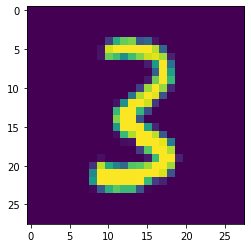

In [181]:
xb, yb = next(iter(dl_valid))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

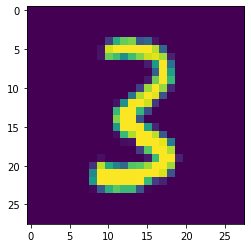

In [182]:
xb, yb = next(iter(dl_valid))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

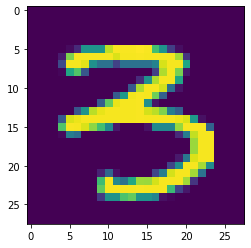

In [183]:
xb, yb = next(iter(dl_train))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(9)

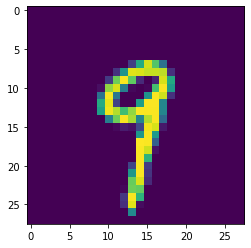

In [184]:
xb, yb = next(iter(dl_train))
plt.imshow(xb[0].view(28,28))
yb[0]

## Pytorch DataLoader

In [233]:
# export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [188]:
dl_train = DataLoader(ds_train, bs, sampler=RandomSampler(ds_train), collate_fn=collate_fn)
dl_valid = DataLoader(ds_valid, bs, sampler=SequentialSampler(ds_valid), collate_fn=collate_fn)

In [190]:
model,opt = get_model()
fit(); stats()

(tensor(0.1202, grad_fn=<NllLossBackward>), tensor(0.9531))

In [192]:
dl_train = DataLoader(ds_train, bs, shuffle=True, drop_last=True)
dl_valid = DataLoader(ds_valid, bs, shuffle=False)

In [193]:
model,opt = get_model()
fit();stats()

(tensor(0.1044, grad_fn=<NllLossBackward>), tensor(0.9688))

In [216]:
def fit(model, epochs, loss_func, opt, dl_train, dl_valid):
    for epoch in range(epochs):
        model.train()
        for xb, yb in dl_train:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()
        tot_correct = tot_loss = tot_seen = 0
        with torch.no_grad():
            for xb, yb in dl_valid:
                preds = model(xb)
                loss = loss_func(preds, yb)
                tot_correct += accuracy(preds, yb).item() * len(xb)
                tot_loss += loss.item() * len(xb)
                tot_seen += len(xb)
            print(f"Acc:{tot_correct/tot_seen:<10}| Loss:{(tot_loss/tot_seen)}")

In [217]:
model, opt = get_model()
fit(model, 10, nn.CrossEntropyLoss(), opt, dl_train, dl_valid)

Acc:0.9247    | Loss:0.26583040053844453
Acc:0.9413    | Loss:0.20672331719398498
Acc:0.9498    | Loss:0.1762784543633461
Acc:0.9538    | Loss:0.15970345425605775
Acc:0.9606    | Loss:0.14108693509697914
Acc:0.9621    | Loss:0.13135480370521546
Acc:0.9661    | Loss:0.1209052057504654
Acc:0.9687    | Loss:0.11313683553338051
Acc:0.9688    | Loss:0.11137832363545895
Acc:0.9694    | Loss:0.10753029338568448


In [237]:
# export
def get_dls(ds_train, ds_valid, bs, **kwargs):
    return (DataLoader(ds_train, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(ds_valid, batch_size=bs*2, **kwargs))

In [225]:
dl_train, dl_valid = get_dls(ds_train, ds_valid, bs)
model, opt = get_model()
fit(model, 5, nn.CrossEntropyLoss(), opt, dl_train, dl_valid)


Acc:0.9076    | Loss:0.31090502943992615
Acc:0.9368    | Loss:0.22862556113004684
Acc:0.9397    | Loss:0.21108992350697517
Acc:0.9566    | Loss:0.15490732422471046
Acc:0.9604    | Loss:0.14133806959986686


## Export

In [238]:
!python notebook2script.py 03_minibatch.ipynb

Converted 03_minibatch.ipynb to exp/nb_03.py
